# COMP 550 PROJECT
Exploring the effect of adding POS tag and parse tree information to pretrained word embeddings on text classification.

## Environment

In [0]:
# mount google drive and upload datafiles
from google.colab import drive
drive.mount('/content/drive')

upload_files = False
if upload_files:
  from google.colab import files
  uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# install dependencies
!pip install --quiet "tensorflow>=1.7"
!pip install tensorflow-hub
!pip install seaborn
!pip install spacy
!pip install gensim

In [1]:
# import dependencies
import tensorflow as tf
import numpy as np

import os
import pandas as pd
import math
from tqdm import tqdm

import gensim
import spacy
import re

import matplotlib.pyplot as plt

c:\users\stefan wapnick\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [0]:
# download models
!python -m spacy download en_core_web_md


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_md -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')



In [0]:
!ls -R

## Data
Note:  
preprocessed form of text might cause issues with pos-tagger and parse tree generator. Look into getting raw text, or just use toxic comments instead. 

### IMDB reviews from tf api

In [2]:
# download data
from tensorflow import keras
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data()

In [3]:
# convert from integers to text
word_index = imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

train_x = [decode_review(x) for x in train_data]
test_x = [decode_review(x) for x in test_data]

In [4]:
display(train_x[:5])
display(test_x[:5])

["<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and s

["<START> please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss",
 "<START> this film requires a lot of patience because it focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in frances austen's the sandy dennis character apartment but the film builds to a disturbing climax br br the characters create an atmosphere rife with sexual tension and psychological trickery it's very interesting that robert altman directed this considering the style and structure of his other films still the trademark altman audio style is evident here and there i think what really makes this film work is the brilliant performance by sandy dennis it's defin

### Toxic comment classification from local dataframe pkl

In [0]:
# TODO:  todo

## Train/Dev/Test Split

In [7]:
SAVE_PATH_FOLDER = os.path.join('drive', 'My Drive', 'Comp550data')


def train_dev_test_split(text, labels, train_split, save_file):
    cache_file = os.path.join(SAVE_PATH_FOLDER, save_file)

    if not os.path.exists(SAVE_PATH_FOLDER):
        os.makedirs(SAVE_PATH_FOLDER)

    if os.path.exists(cache_file):
        print('Loading existing experiment data: %s' % cache_file)
        pickle_in = open(cache_file, 'rb')
        return pickle.load(pickle_in)

    df = pd.DataFrame()
    df['x'] = text
    df['y'] = labels
    labels = df['y'].unique()
    df = df.sample(frac=1).reset_index(drop=True)

    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    dev_data = []
    dev_labels = []

    for label in labels:
        class_instances = df.loc[df['y'] == label]
        nb_train_dev = int(len(class_instances) * train_split)
        nb_train = int(nb_train_dev * 0.9)
        train_dev_instances = class_instances.iloc[:nb_train_dev]
        test_instances = class_instances.iloc[nb_train_dev:]
        train_instances = train_dev_instances.iloc[:nb_train]
        dev_instances = train_dev_instances.iloc[nb_train:]

        train_data = train_data + train_instances['x'].tolist()
        train_labels = train_labels + train_instances['y'].tolist()
        test_data = test_data + test_instances['x'].tolist()
        test_labels = test_labels + test_instances['y'].tolist()
        dev_data = dev_data + dev_instances['x'].tolist()
        dev_labels = dev_labels + dev_instances['y'].tolist()

    train_dev_test_sets = (train_data, train_labels), \
                          (dev_data, dev_labels), \
                          (test_data, test_labels)

    with open(cache_file, 'wb') as f:
        print('Saving experiment data: %s' % cache_file)
        pickle.dump(train_dev_test_sets, f)

    return train_dev_test_sets

## Model

### Pretrained Embeddings

In [5]:
# gensim wv model
import gensim
import gensim.downloader as gensim_api
gensim_glove_100 = gensim_api.load("glove-wiki-gigaword-100")
gensim_glove_100["terrible"]

array([ 0.23329 ,  0.010617,  0.42689 , -0.32641 , -1.0809  ,  0.25532 ,
       -0.4322  ,  0.15733 ,  0.15852 , -0.26616 ,  0.030956,  0.21665 ,
       -0.21391 , -0.061479, -0.054855,  0.50001 , -0.77447 ,  0.089656,
       -0.73531 ,  0.61803 ,  0.118   ,  0.18501 , -0.073202, -0.21066 ,
        0.15761 ,  0.22562 , -0.3406  ,  0.47012 ,  0.47449 , -0.61687 ,
        0.25747 , -0.24729 ,  0.012812, -0.16493 , -0.8882  , -0.47489 ,
       -0.52072 , -0.12297 ,  0.77504 , -0.089192, -0.18547 ,  0.83209 ,
        0.15041 , -0.47365 ,  0.1489  ,  0.48985 ,  1.0188  ,  0.20297 ,
       -0.56428 , -0.67022 ,  0.2263  , -0.060194,  0.20877 ,  0.63827 ,
        0.098412, -1.6901  ,  0.70448 ,  0.79248 ,  0.45988 ,  0.085941,
       -0.11283 ,  0.80774 , -1.3575  , -1.0195  ,  0.49793 , -0.24394 ,
        0.46319 , -0.33754 , -0.54731 , -0.47561 , -0.25493 , -0.35981 ,
        0.19464 ,  0.66821 ,  1.0873  ,  0.55029 , -0.14909 ,  0.24495 ,
       -0.37286 ,  1.0092  ,  0.74697 ,  0.49547 , 

### POS tags

In [6]:
from nltk import load

spacy_pos_dict = { 
              'ADJ': 0,
              'ADP': 1,
              'ADV': 2,
              'AUX': 3,
              'CONJ': 4,
              'DET': 5,
              'INTJ': 6,
              'NOUN': 7,
              'NUM': 8,
              'PART': 9,
              'PRON': 10,
              'PROPN': 11,
              'PUNCT': 12,
              'SCONJ':  13,
              'SYM': 14,
              'VERB': 15,
              'X': 16
            }

upenn_tagset = load('help/tagsets/upenn_tagset.pickle')
nltk_pos_dict = {key: i for (i,key) in enumerate(upenn_tagset.keys())}
print(nltk_pos_dict)

{'LS': 0, 'TO': 1, 'VBN': 2, "''": 3, 'WP': 4, 'UH': 5, 'VBG': 6, 'JJ': 7, 'VBZ': 8, '--': 9, 'VBP': 10, 'NN': 11, 'DT': 12, 'PRP': 13, ':': 14, 'WP$': 15, 'NNPS': 16, 'PRP$': 17, 'WDT': 18, '(': 19, ')': 20, '.': 21, ',': 22, '``': 23, '$': 24, 'RB': 25, 'RBR': 26, 'RBS': 27, 'VBD': 28, 'IN': 29, 'FW': 30, 'RP': 31, 'JJR': 32, 'JJS': 33, 'PDT': 34, 'MD': 35, 'VB': 36, 'WRB': 37, 'NNP': 38, 'EX': 39, 'NNS': 40, 'SYM': 41, 'CC': 42, 'CD': 43, 'POS': 44}


In [10]:
import nltk
nltk.download('tagsets')

[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

In [0]:
# spacy_model = spacy.load('en_core_web_md')
text = "This movie was terrible, for shame!!!"
doc = spacy_model(text)

for token in doc:
  print("Token: {0}\nPOS: {1}\n\n".format(token, token.pos_))

Token: This
POS: DET


Token: movie
POS: NOUN


Token: was
POS: VERB


Token: terrible
POS: ADJ


Token: ,
POS: PUNCT


Token: for
POS: ADP


Token: shame
POS: NOUN


Token: !
POS: PUNCT


Token: !
POS: PUNCT


Token: !
POS: PUNCT




### Sequence Class

In [7]:
from keras.utils import Sequence
from nltk import pos_tag
import math

# TODO: handle dim depending on input

WV_DIM = 100
POS_DIM = len(nltk_pos_dict)
PARSE_DIM = 0
WV_DIM = WV_DIM + POS_DIM + PARSE_DIM
MAX_SENT_LEN = 200

class TextSequence(Sequence):
  
  def __init__(self, x_set, y_set, batch_size, 
               use_pos_tags=True, use_parse_tree=False,
               pretrained_wv='gensim-glove-100'):
    
    self.x, self.y = x_set, y_set
    self.batch_size = batch_size
    self.use_pos_tags = use_pos_tags
    self.use_parse_tree = use_parse_tree
    self.pretrained_wv = pretrained_wv

  def __len__(self):
    return math.ceil(len(self.x) / self.batch_size)
  
  def __getitem__(self, idx):
    # build batches
    batch_start = idx*self.batch_size
    batch_end = batch_start + self.batch_size
    batch_x = self.x[batch_start:batch_end]
    batch_y = self.y[batch_start:batch_end]
    
    # process batches
    processed_batch_x = self.batch_x_process(batch_x)
    processed_batch_y = self.batch_y_process(batch_y)
    
    return processed_batch_x, processed_batch_y
  
  
  
  def batch_x_process(self, batch_x):
    return np.array([
        self.x_process(x)
        for x in batch_x])
  
  def batch_y_process(self, batch_y):
    return np.array([
        self.y_process(y)
        for y in batch_y])
  
  
  
  def x_process(self, text):
    # create embedding matrix for text
    wv_tensor = np.zeros((MAX_SENT_LEN, WV_DIM))
    for i,w in enumerate(text.split()):
    # for i,w in enumerate(spacy_model(text)):      
      if i>=MAX_SENT_LEN:
        break
      wv_tensor[i] = self.build_token_embedding(w)
    return wv_tensor
  
  def y_process(self, y):
    return y
  
  
  
  def build_token_embedding(self, w):      
    # build pretrained embedding    
    if self.pretrained_wv == 'gensim-glove-100':
      try:
        wv = gensim_glove_100[w]
      except:
        wv = np.zeros((1,100))
        
    # build pos tag embedding
    if self.use_pos_tags:
      try:
        i = nltk_pos_dict[pos_tuple[1]]
      except:
        i = len(nltk_pos_dict)-1 # index for 'X' (aka other) pos tag  
        
    pos_v = np.eye(POS_DIM)[i]
    wv = np.concatenate((wv, pos_v), axis=None)
        
    return wv

Using TensorFlow backend.


In [0]:
# COPY OF TEXT SEQUENCE
# =======================================
from keras.utils import Sequence
from nltk import pos_tag

# TODO: handle dim depending on input

WV_DIM = 100
POS_DIM = 17
PARSE_DIM = 0
WV_DIM = WV_DIM + POS_DIM + PARSE_DIM
MAX_SENT_LEN = 200

class TextSequence(Sequence):
  
  def __init__(self, x_set, y_set, batch_size, 
               use_pos_tags=True, use_parse_tree=False,
               pretrained_wv='gensim-glove-100'):
    
    self.x, self.y = x_set, y_set
    self.batch_size = batch_size
    self.use_pos_tags = use_pos_tags
    self.use_parse_tree = use_parse_tree
    self.pretrained_wv = pretrained_wv

  def __len__(self):
    return math.ceil(len(self.x) / self.batch_size)
  
  def __getitem__(self, idx):
    # build batches
    batch_start = idx*self.batch_size
    batch_end = batch_start + self.batch_size
    batch_x = self.x[batch_start:batch_end]
    batch_y = self.y[batch_start:batch_end]
    
    # process batches
    processed_batch_x = self.batch_x_process(batch_x)
    processed_batch_y = self.batch_y_process(batch_y)
    
    return processed_batch_x, processed_batch_y
  
  
  
  def batch_x_process(self, batch_x):
    return np.array([
        self.x_process(x)
        for x in batch_x])
  
  def batch_y_process(self, batch_y):
    return np.array([
        self.y_process(y)
        for y in batch_y])
  
  
  
  def x_process(self, text):
    # create embedding matrix for text
    wv_tensor = np.zeros((MAX_SENT_LEN, WV_DIM))
    for i,w in enumerate(text.split()):
    # for i,w in enumerate(spacy_model(text)):      
      if i>=MAX_SENT_LEN:
        break
      wv_tensor[i] = self.build_token_embedding(pos_tag(w))
    return wv_tensor
  
  def y_process(self, y):
    return y
  
  
  
  def build_token_embedding(self, spacy_token):      
    # build pretrained embedding    
    if self.pretrained_wv == 'gensim-glove-100':
      try:
        wv = gensim_glove_100[spacy_token]
      except:
        wv = np.zeros((1,100))
        
    # build pos tag embedding
    if self.use_pos_tags:
      try:
        i = spacy_pos_dict[spacy_token.pos]
      except:
        i = 16 # index for 'X' (aka other) pos tag  
        
      pos_v = np.eye(POS_DIM)[i]
      wv = np.concatenate((wv, pos_v), axis=None)
        
    return wv

### Batch preprocess

In [8]:
use_pos_tags = True
pretrained_wv = 'gensim-glove-100'

def x_process(text):
  # create embedding matrix for text
  wv_tensor = np.zeros((MAX_SENT_LEN, WV_DIM))
  for i,w in enumerate(pos_tag(text.split())):
  # for i,w in enumerate(spacy_model(text)):      
    if i>=MAX_SENT_LEN:
      break
    wv_tensor[i] = build_token_embedding(w)
  return wv_tensor


def build_token_embedding(pos_tuple):      
  # build pretrained embedding    
  if pretrained_wv == 'gensim-glove-100':
    try:
      wv = gensim_glove_100[pos_tuple[0]]
    except:
      wv = np.zeros((1,100))

  # build pos tag embedding
  if use_pos_tags:
    try:
      i = nltk_pos_dict[pos_tuple[1]]
    except:
      i = len(nltk_pos_dict)-1 # index for 'X' (aka other) pos tag  

    pos_v = np.eye(POS_DIM)[i]
    wv = np.concatenate((wv, pos_v), axis=None)

  return wv

In [42]:
def x_process(text):
  wv_tensor = np.zeros((MAX_SENT_LEN, POS_DIM))
  for i,w in enumerate(pos_tag(text.split())):  
    if i>=MAX_SENT_LEN:
      break
    wv_tensor[i] = build_token_embedding(w)
  return wv_tensor


def build_token_embedding(pos_tuple):   
    try:
      i = nltk_pos_dict[pos_tuple[1]]
    except:
      i = len(nltk_pos_dict)-1 # index for 'X' (aka other) pos tag  

    return np.eye(POS_DIM)[i]
  

In [47]:
from tqdm import tqdm_notebook
train_x_wv = [x_process(x) for x in tqdm_notebook(train_x)]





  6%|█████████▉                                                                                                                                                             | 1489/25000 [00:38<05:12, 75.28it/s]

In [34]:
display(train_x[0].split())
display(train_x_wv[0][1])
pos_tag(["this"])
nltk_pos_dict


['<START>',
 'this',
 'film',
 'was',
 'just',
 'brilliant',
 'casting',
 'location',
 'scenery',
 'story',
 'direction',
 "everyone's",
 'really',
 'suited',
 'the',
 'part',
 'they',
 'played',
 'and',
 'you',
 'could',
 'just',
 'imagine',
 'being',
 'there',
 'robert',
 "redford's",
 'is',
 'an',
 'amazing',
 'actor',
 'and',
 'now',
 'the',
 'same',
 'being',
 'director',
 "norman's",
 'father',
 'came',
 'from',
 'the',
 'same',
 'scottish',
 'island',
 'as',
 'myself',
 'so',
 'i',
 'loved',
 'the',
 'fact',
 'there',
 'was',
 'a',
 'real',
 'connection',
 'with',
 'this',
 'film',
 'the',
 'witty',
 'remarks',
 'throughout',
 'the',
 'film',
 'were',
 'great',
 'it',
 'was',
 'just',
 'brilliant',
 'so',
 'much',
 'that',
 'i',
 'bought',
 'the',
 'film',
 'as',
 'soon',
 'as',
 'it',
 'was',
 'released',
 'for',
 'retail',
 'and',
 'would',
 'recommend',
 'it',
 'to',
 'everyone',
 'to',
 'watch',
 'and',
 'the',
 'fly',
 'fishing',
 'was',
 'amazing',
 'really',
 'cried',
 'a

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

{'LS': 0,
 'TO': 1,
 'VBN': 2,
 "''": 3,
 'WP': 4,
 'UH': 5,
 'VBG': 6,
 'JJ': 7,
 'VBZ': 8,
 '--': 9,
 'VBP': 10,
 'NN': 11,
 'DT': 12,
 'PRP': 13,
 ':': 14,
 'WP$': 15,
 'NNPS': 16,
 'PRP$': 17,
 'WDT': 18,
 '(': 19,
 ')': 20,
 '.': 21,
 ',': 22,
 '``': 23,
 '$': 24,
 'RB': 25,
 'RBR': 26,
 'RBS': 27,
 'VBD': 28,
 'IN': 29,
 'FW': 30,
 'RP': 31,
 'JJR': 32,
 'JJS': 33,
 'PDT': 34,
 'MD': 35,
 'VB': 36,
 'WRB': 37,
 'NNP': 38,
 'EX': 39,
 'NNS': 40,
 'SYM': 41,
 'CC': 42,
 'CD': 43,
 'POS': 44}

In [48]:
df = pd.DataFrame()
df['text'] = train_x
df['pos'] = train_x_wv
df['label'] = train_labels

df.to_pickle('nltk_pos_dataframe.pkl')


In [18]:
import pandas as pd
import numpy as np

# df = pd.read_pickle('nltk_pos_dataframe.pkl')

np.array(list(df['pos'][0:5])).shape


(5, 200, 45)

In [67]:
!ls -R

.:
drive  sample_data

./drive:
'My Drive'

'./drive/My Drive':
 A1_Team14		       ComputerVisionNotes.rtf
 A1_Team14.zip		       coop2013
 A2_Team14.zip		       CPPTemplates.rtfd
 AlgorithmsSummary.rtf	       JupyterTest
 Assignment2.docx	       LexicalVsOrthoAmbiguity.rtf
 Assignment2.m		       MachineLearning
 Bishop_Notes.docx	       MATLAB_Notes.docx
 CasesOfAmbiguity.rtf	       McGillAdmission.pdf
 ChromeExtensions_Notes.docx   McGillCourses.docx
 C++_Notes.docx		       MySql_Exerises
'Colab Notebooks'	       NlpFeatureSelection.rtf
 Comp5421_AdvProgramming       NLPNotes.rtf
 Comp550		       NSERCApplication
 Comp550data		       OpenCv
 COMP5531		      'Presentation copy.pptx'
 COMP5531Project	       Presentation.pptx
 Comp5541		       PythonNotes
 Comp557		       ReactNative_Notes.docx
 Comp558		       Resume_StefanWapnickMcGill.docx
 Comp561		       rt-polaritydata
 Comp601		       scrap.m
 Comp6231		       SQL_Notes.docx
 COMP6231A1Submission	      'Test doc.gdoc'
 Comp6231Pr

### Keras model

In [16]:
# model design
from keras.layers import Dense, Input, CuDNNLSTM, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [0]:
I = Input(shape=(MAX_SENT_LEN, WV_DIM))
embedded_sequences = SpatialDropout1D(0.1)(I)
x = Bidirectional(CuDNNLSTM(64, return_sequences=False))(embedded_sequences)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[I], outputs=preds)

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=['accuracy'])


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 200, 117)          0         
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 200, 117)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               93696     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 94,337
Trainable params: 94,081
Non-trainable params: 256
_________________________________________________________________


In [47]:
# model fit/train
training_generator = TextSequence(train_x, train_labels, 512, use_pos_tags=False)
hist = model.fit_generator(training_generator, epochs=20)

Epoch 1/20
35/49 [====================>.........] - ETA: 13s - loss: 0.7266 - acc: 0.5789

KeyboardInterrupt: ignored

In [0]:
history = pd.DataFrame(hist.history)
plt.figure(figsize=(12,12));
plt.plot(history["loss"]);
# plt.plot(history["val_loss"]);
plt.title("Loss with pretrained word vectors");
plt.show();

In [0]:
model.save("drive/My Drive/NLP Pipeline/data/keras_bilstm_spacy-fasttext-sequence_12-04-2018")

In [0]:
# confusion matrix
testing_generator = TextSequence(x_test, y_test, 256)
y_pred = model.predict_generator(testing_generator)
cm = tf.confusion_matrix(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1), num_classes=3)

with tf.Session() as session:
    cm_out = session.run(cm)
y_labels =  pd.get_dummies(df_train.label.values).columns
sns.heatmap(cm_out, annot=True, xticklabels=y_labels.values, yticklabels=y_labels.values);
plt.xlabel("Predicted");
plt.ylabel("True");

# Deep Learning Based Emotion Recognition with TensorFlow

![alt txt](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/img/emotion_classifier.png?raw=true)

In this notebook we are going to learn how to train deep neural networks, such as recurrent neural networks (RNNs), for addressing a natural language task known as **emotion recognition**. We will cover everything you need to know to get started with NLP using deep learning frameworks such as TensorFlow. We will cover the common best practices, functionalities, and steps you need to understand the basics of TensorFlow APIs to build powerful predictive models via the computation graph. In the process of building our models, we will compare PyTorch and TensorFlow to let the learner appreciate the strenghts of each tool.

by [Elvis Saravia](https://twitter.com/omarsar0)

---

## Outline
1. Deep Learning Frameworks
     - 1.1 Eager execution
     - 1.2 Computation graph
2. Tensors
    - 2.1 Basic math with tensors
    - 2.2 Transforming tensors
3. Data
    - 3.1 Preprocessing data
        - Tokenization and Sampling
        - Constructing Vocabulary and Index-Word Mapping
    - 3.2 Converting data into tensors
    - 3.3 Padding data
    - 3.4 Binarization
    - 3.5 Split data
    - 3.6 Data Loader
4. Model
    - 4.1 Pretesting Model
    - 4.2 Testing models with eager execution
5. Training
6. Evaluation on Testing Dataset
    - 6.1 Confusion matrix
- Final Words
- References
- *Storing models and setting checkpoints (Exercise)*
- *Restoring models (Exercise)*

---

## 1. Deep Learning Frameworks
There are many deep learning frameworks such as Chainer, DyNet, MXNet, PyTorch, TensorFlow, and Keras. Each framework has their own strenghts which a researcher or a developer may want to consider before choosing the right framework. In my opinion, PyTorch is great for researchers and offers eager execution by default, but its high-level APIs require some understanding of deep learning concepts such as **affine layers** and **automatic differentiation**. On the other hand, TensorFlow was originally built as a low-level API that provides a robust list of functionalities to build deep learning models from the ground up. More recently, TensorFlow also offers **eager execution** and is equipped with a high-level API known as Keras.

![alt txt](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/img/dl_frameworks.png?raw=true)

### 1.1 Eager Execution
Eager execution allows us to operate on the computation graph dynamically, also known as **imperative programming**. TensorFlow requires that you manually turn this mode on, while PyTorch comes with this mode by default. Below we import the necessary library and enable eager execution.

In [0]:
import tensorflow as tf
tf.enable_eager_execution()
print(tf.__version__)
print("EE enabled?", tf.executing_eagerly())

1.12.0
EE enabled? True


### 1.2 Computation Graph
A simplified definition of a neural network is a string of functions that are **differentiable** and that we can combine together to get more complicated functions. An intuitive way to express this process is through computation graphs. 

![alt txt](http://colah.github.io/posts/2015-08-Backprop/img/tree-eval-derivs.png)

Image credit: [Chris Olah](http://colah.github.io/posts/2015-08-Backprop/)

## 2. Tensors
Tensors are the fundamental data structure used to store data that will be fed as input to a computation graph for processing and applying tranformations. Let's create two tensors and multiply them, and then output the result. The figure below shows a 4-D Tensor.

![alt txt](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/img/tensor.png?raw=true)

In [0]:
c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])
e = tf.matmul(c, d)
print(e)

tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)


### 2.1 Math with Tensors
TensorFlow and other deep learning libraries like PyTorch allow you to do **automatic differentation**. Let's try to compute the derivative of a function -- in this case that function is stored in the variable `z`. In TensorFlow, the `tf.GradienTape()` function allows tracking of operations on the input tensor. 

In [0]:
### Automatic differentiation with TensorFlow

x = tf.contrib.eager.Variable(tf.ones((2,2)))
with tf.GradientTape() as tape:
    y = x + 2
    z = y * y * 3
    out = tf.reduce_mean(z)

grad = tape.gradient(out, x) # d(out)/dx
print(grad)

tf.Tensor(
[[4.5 4.5]
 [4.5 4.5]], shape=(2, 2), dtype=float32)


You can verfiy the output with the equations in the figure below:

![alt txt](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/img/autograd.jpg?raw=true)

### 2.2 Transforming Tensors
We can also apply some transformation to a tensor such as adding a dimension or transposing it. Let's try both adding a dimension and transposing a matrix below.

In [0]:
x = tf.constant([[1, 2, 3], [4, 5, 6]])
print("X shape: ", x.shape)

# add dimension
print(tf.shape(tf.expand_dims(x, 1)))

# transpose
tf.transpose(x).shape

X shape:  (2, 3)
tf.Tensor([2 1 3], shape=(3,), dtype=int32)


TensorShape([Dimension(3), Dimension(2)])

---

## 3. Emotion Dataset
In this notebook we are working on an emotion classification task. We are using the public emotion dataset provided [here](https://github.com/huseinzol05/NLP-Dataset/tree/master/emotion-english). The dataset contains tweets labeled into 6 categories.

In [0]:
import re
import numpy as np
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [0]:
### Helper functions
import pickle

def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))


def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

In [0]:
### read data from your Google Drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


We had already processed the data for you. You can find the pickle file [here](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/data/merged_training.pkl).

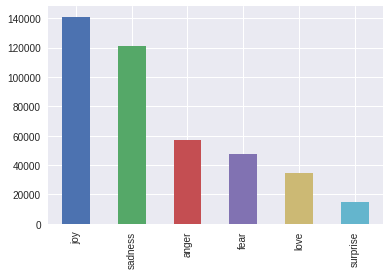

In [0]:
# load data
data = load_from_pickle(directory="/gdrive/My Drive/DAIR RESOURCES/TensorFlow/emotion_recognition/merged_training.pkl")
data.emotions.value_counts().plot.bar()

In [0]:
data.head(10)

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
18231,i find myself frustrated with christians becau...,love
10714,i am one of those people who feels like going ...,joy
35177,i feel especially pleased about this as this h...,joy
122177,i was struggling with these awful feelings and...,joy
26723,i feel so enraged but helpless at the same time,anger


### 3.1 Preprocessing Data
In the next steps we are going to create tokenize the text, create index mapping for words, and also construct a vocabulary. 

#### Tokenization and Sampling

In [0]:
# retain only text that contain less that 70 tokens to avoid too much padding
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 70].copy()

# sampling
data = data.sample(n=50000);

#### Constructing Vocabulary and Index-Word Mapping

In [0]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

In [0]:
# construct vocab and indexing
inputs = ConstructVocab(data["text"].values.tolist())

# examples of what is in the vocab
inputs.vocab[0:10]

['a',
 'aaa',
 'aaaaaand',
 'aaaah',
 'aaand',
 'aaargh',
 'aabsolutely',
 'aahed',
 'aand',
 'aardvark']

### 3.2 Converting Data into Tensors 
For convenience we would like to convert the data into tensors. 

In [0]:
# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [0]:
# examples of what is in the input tensors
input_tensor[0:2]

[[11616,
  8726,
  23997,
  8037,
  9463,
  9497,
  17034,
  11716,
  18637,
  26054,
  27128,
  22289],
 [11616,
  26288,
  8735,
  24515,
  14184,
  1451,
  26865,
  27092,
  24430,
  18196,
  22293,
  11616,
  6475,
  23637]]

### 3.3 Padding data
In order to train our recurrent neural network later on in the notebook, it is required padding to generate inputs of same length.

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

69


In [0]:
# Padding the input and output tensor to the maximum length
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                             maxlen=max_length_inp,
                                                             padding='post')

In [0]:
input_tensor[0:2]

array([[11616,  8726, 23997,  8037,  9463,  9497, 17034, 11716, 18637,
        26054, 27128, 22289,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [11616, 26288,  8735, 24515, 14184,  1451, 26865, 27092, 24430,
        18196, 22293, 11616,  6475, 23637,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     

### 3.4 Binarization
We would like to binarize our target so that we can obtain one-hot encodings as target values. These are easier and more efficient to work with and will be useful when training the models.

In [0]:
### convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [0]:
target_tensor[0:2] 

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0]])

In [0]:
data[0:2]

,text,emotions,token_size
56648,i feel terrible especially friends from owt il...,sadness,12
102135,i was feeling too lousy at work yesterday to p...,sadness,14


In [0]:
get_emotion = lambda t: np.argmax(t)

In [0]:
get_emotion(target_tensor[0])

4

In [0]:
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [0]:
emotion_dict[get_emotion(target_tensor[0])]

'sadness'

### 3.5 Split data
We would like to split our data into a train and validation set. In addition, we also want a holdout dataset (test set) for evaluating the models.

In [0]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(40000, 40000, 5000, 5000, 5000, 5000)

### 3.6 Data Loader
We can also load the data into a data loader, which makes it easy to **manipulate the data**, **create batches**, and apply further **transformations**. In TensorFlow we can use the `tf.data` function.

In [0]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = num_emotions

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, 
                                                    target_tensor_train)).shuffle(TRAIN_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, 
                                                  target_tensor_val)).shuffle(VAL_BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, 
                                                    target_tensor_test)).shuffle(TEST_BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
# checking minibatch
print(train_dataset)
print(val_dataset)
print(test_dataset)

<BatchDataset shapes: ((64, 69), (64, 6)), types: (tf.int32, tf.int64)>
<BatchDataset shapes: ((64, 69), (64, 6)), types: (tf.int32, tf.int64)>
<BatchDataset shapes: ((64, 69), (64, 6)), types: (tf.int32, tf.int64)>


## 4. Model
After the data has been preprocessed, transformed and prepared it is now time to construct the model or the so-called computation graph that will be used to train our classification models. We are going to use a gated recurrent neural network (GRU), which is considered a more efficient version of a basic RNN. The figure below shows a high-level overview of the model details. 

![alt txt](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/img/gru-model.png?raw=true)

### 4.1 Constructing the Model
Below we construct our model:

In [0]:
### define the GRU component
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='relu', 
                               recurrent_initializer='glorot_uniform')

### Build the model
class EmoGRU(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        
        # layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.gru = gru(self.hidden_units)
        self.fc = tf.keras.layers.Dense(output_size)
        
    def call(self, x, hidden):
        x = self.embedding(x) # batch_size X max_len X embedding_dim
        output, state = self.gru(x, initial_state = hidden) #  batch_size X max_len X hidden_units
        out = output[:,-1,:]
        out = self.dropout(out)
        out = self.fc(out) # batch_size X max_len X output_size
        return out, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.hidden_units))

### 4.1 Pretesting model
Since eager execution is enabled we can print the output of the model by passing a sample of the dataset and making sure that the dimensions of the outputs are as expected.

In [0]:
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)

# initialize the hidden state of the RNN
hidden = model.initialize_hidden_state()

# testing for the first batch only then break the for loop
# Potential bug: out is not randomized enough
for (batch, (inp, targ)) in enumerate(train_dataset):
    out, state = model(inp, hidden)
    print(out.shape) 
    break

(64, 6)


## 5. Training the Model
Now that we have tested the model, it is time to train it. We will define our optimization algorithm, learning rate, and other necessary information to train the model.

In [0]:
optimizer = tf.train.AdamOptimizer()

def loss_function(y, prediction):
    return tf.losses.softmax_cross_entropy(y, logits=prediction)

def accuracy(y, yhat):
    #compare the predictions to the truth
    yhat = tf.argmax(yhat, 1).numpy()
    y    = tf.argmax(y   , 1).numpy()
    return np.sum(y == yhat)/len(y)

In [0]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    hidden = model.initialize_hidden_state()
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ)) in enumerate(train_dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            predictions,_ = model(inp, hidden)
            loss += loss_function(targ, predictions)
        batch_loss = (loss / int(targ.shape[1]))        
        total_loss += batch_loss
        
        batch_accuracy = accuracy(targ, predictions)
        train_accuracy += batch_accuracy
        
        gradients = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(gradients, model.variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
            
    ### Validating
    hidden = model.initialize_hidden_state()

    for (batch, (inp, targ)) in enumerate(val_dataset):        
        predictions,_ = model(inp, hidden)        
        batch_accuracy = accuracy(targ, predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             total_loss / TRAIN_N_BATCH, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.2983
Epoch 1 Batch 100 Val. Loss 0.2562
Epoch 1 Batch 200 Val. Loss 0.2513
Epoch 1 Batch 300 Val. Loss 0.2547
Epoch 1 Batch 400 Val. Loss 0.2642
Epoch 1 Batch 500 Val. Loss 0.2537
Epoch 1 Batch 600 Val. Loss 0.2552
Epoch 1 Loss 0.2629 -- Train Acc. 0.3323 -- Val Acc. 0.3321
Time taken for 1 epoch 65.13817477226257 sec

Epoch 2 Batch 0 Val. Loss 0.2466
Epoch 2 Batch 100 Val. Loss 0.2271
Epoch 2 Batch 200 Val. Loss 0.0703
Epoch 2 Batch 300 Val. Loss 0.0607
Epoch 2 Batch 400 Val. Loss 0.0353
Epoch 2 Batch 500 Val. Loss 0.0300
Epoch 2 Batch 600 Val. Loss 0.0131
Epoch 2 Loss 0.0990 -- Train Acc. 0.7551 -- Val Acc. 0.9331
Time taken for 1 epoch 65.25825381278992 sec

Epoch 3 Batch 0 Val. Loss 0.0382
Epoch 3 Batch 100 Val. Loss 0.0201
Epoch 3 Batch 200 Val. Loss 0.0182
Epoch 3 Batch 300 Val. Loss 0.0177
Epoch 3 Batch 400 Val. Loss 0.0205
Epoch 3 Batch 500 Val. Loss 0.0076
Epoch 3 Batch 600 Val. Loss 0.0271
Epoch 3 Loss 0.0206 -- Train Acc. 0.9375 -- Val Acc. 0.9359

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  6980864   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
cu_dnngru (CuDNNGRU)         multiple                  3938304   
_________________________________________________________________
dense (Dense)                multiple                  6150      
Total params: 10,925,318
Trainable params: 10,925,318
Non-trainable params: 0
_________________________________________________________________


## 6. Evaluation on the Testing Data
Now we will evaluate the model with the holdout dataset.

In [0]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

hidden = model.initialize_hidden_state()

for (batch, (inp, targ)) in enumerate(test_dataset):        
    predictions,_ = model(inp, hidden)        
    batch_accuracy = accuracy(targ, predictions)
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy/TEST_N_BATCH)

Test Accuracy:  0.9274839743589743


### 6.1 Confusion Matrix
The test accuracy alone is not an interesting performance metric in this case. Let's plot a confusion matrix to get a drilled down view of how the model is performing with regards to each emotion.

In [0]:
### Class to Properly Evaluate our Models
class Evaluate():

    def va_dist(cls, prediction, target, va_df, binarizer, name='', silent=False):
        """ Computes distance between actual and prediction through cosine distance """
        va_matrix = va_df.loc[binarizer.classes_][['valence','arousal']].values
        y_va = target.dot(va_matrix)
        F_va = prediction.dot(va_matrix)

        # dist is a one row vector with size of the test data passed(emotion)
        dist = metrics.pairwise.paired_cosine_distances(y_va, F_va)
        res = stats.describe(dist)

        # print by default (if silent=False)
        if not silent:
            print('%s\tmean: %f\tvariance: %f' % (name, res.mean, res.variance))

        return {
            'distances': dist,
            'dist_stat': res
        }

    def evaluate_class(cls, predictions, target, target2=None, silent=False):
        """ Compute only the predicted class """
        p_2_annotation = dict()

        precision_recall_fscore_support = [
            (pair[0], pair[1].mean()) for pair in zip(
                ['precision', 'recall', 'f1', 'support'],
                metrics.precision_recall_fscore_support(target, predictions)
            )
        ]

        metrics.precision_recall_fscore_support(target, predictions)

        # confusion matrix
        le = LabelEncoder()
        target_le = le.fit_transform(target)
        predictions_le = le.transform(predictions)
        cm = metrics.confusion_matrix(target_le, predictions_le)

        # prediction if two annotations are given on test data
        if target2:
            p_2_annotation = pd.DataFrame(
                [(pred, pred in set([t1,t2])) for pred, t1, t2 in zip(predictions, target, target2)],
                columns=['emo','success']
            ).groupby('emo').apply(lambda emo: emo.success.sum()/ len(emo.success)).to_dict()

        if not silent:
            print("Default Classification report")
            print(metrics.classification_report(target, predictions))

            # print if target2 was provided
            if len(p_2_annotation) > 0:
                print('\nPrecision on 2 annotations:')
                for emo in p_2_annotation:
                    print("%s: %.2f" % (emo, p_2_annotation[emo]))

            # print accuracies, precision, recall, and f1
            print('\nAccuracy:')
            print(metrics.accuracy_score(target, predictions))
            print("Correct Predictions: ", metrics.accuracy_score(target, predictions,normalize=False))
            for to_print in precision_recall_fscore_support[:3]:
                print( "%s: %.2f" % to_print )

            # normalizing the values of the consfusion matrix
            print('\nconfusion matrix\n %s' % cm)
            print('(row=expected, col=predicted)')
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cls.plot_confusion_matrix(cm_normalized, le.classes_, 'Confusion matrix Normalized')

        return {
            'precision_recall_fscore_support': precision_recall_fscore_support,
            'accuracy': metrics.accuracy_score(target, predictions),
            'p_2_annotation': p_2_annotation,
            'confusion_matrix': cm
        }

    def predict_class(cls, X_train, y_train, X_test, y_test,
                      pipeline, silent=False, target2=None):
        """ Predicted class,then run some performance evaluation """
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_test)
        print("predictions computed....")
        return cls.evaluate_class(predictions, y_test, target2, silent)

    def evaluate_prob(cls, prediction, target_rank, target_class, binarizer, va_df, silent=False, target2=None):
        """ Evaluate through probability """
        # Run normal class evaluator
        predict_class = binarizer.classes_[prediction.argmax(axis=1)]
        class_eval = cls.evaluate_class(predict_class, target_class, target2, silent)

        if not silent:
            print('\n - First Emotion Classification Metrics -')
            print('\n - Multiple Emotion rank Metrics -')
            print('VA Cosine Distance')

        classes_dist = [
            (
                emo,
                cls.va_dist(
                    prediction[np.array(target_class) == emo],
                    target_rank[np.array(target_class) == emo],
                    va_df,
                    binarizer,
                    emo,
                    silent)
                ) for emo in binarizer.classes_
        ]
        avg_dist = cls.va_dist(prediction, target_rank, va_df, binarizer, 'avg', silent)

        coverage_error = metrics.coverage_error(target_rank, prediction)
        average_precision_score = metrics.average_precision_score(target_rank, prediction)
        label_ranking_average_precision_score = metrics.label_ranking_average_precision_score(target_rank, prediction)
        label_ranking_loss = metrics.label_ranking_loss(target_rank, prediction)

        # recall at 2
        # obtain top two predictions
        top2_pred = [set([binarizer.classes_[i[0]], binarizer.classes_[i[1]]]) for i in (prediction.argsort(axis=1).T[-2:].T)]
        recall_at_2 = pd.DataFrame(
            [
            t in p for t, p in zip(target_class, top2_pred)
            ], index=target_class, columns=['recall@2']).groupby(level=0).apply(lambda emo: emo.sum()/len(emo))

        # combine target into sets
        if target2:
            union_target = [set(t) for t in zip(target_class, target2)]
        else:
            union_target = [set(t) for t in zip(target_class)]

        # precision at k
        top_k_pred = [
            [set([binarizer.classes_[i] for i in i_list]) for i_list in (prediction.argsort(axis=1).T[-i:].T)]
            for i in range(2, len(binarizer.classes_)+1)]
        precision_at_k = [
            ('p@' + str(k+2), np.array([len(t & p)/(k+2) for t, p in zip(union_target, top_k_pred[k])]).mean())
            for k in range(len(top_k_pred))]

        # do this if silent= False
        if not silent:
            print('\n')
            print(recall_at_2)
            print('\n')
            print('p@k')
            for pk in precision_at_k:
                print(pk[0] + ':\t' + str(pk[1]))
            print('\ncoverage_error: %f' % coverage_error)
            print('average_precision_score: %f' % average_precision_score)
            print('label_ranking_average_precision_score: %f' % label_ranking_average_precision_score)
            print('label_ranking_loss: %f' % label_ranking_loss)

        return {
            'class_eval': class_eval,
            'recall_at_2': recall_at_2.to_dict(),
            'precision_at_2': precision_at_k,
            'classes_dist': classes_dist,
            'avg_dist': avg_dist,
            'coverage_error': coverage_error,
            'average_precision_score': average_precision_score,
            'label_ranking_average_precision_score': label_ranking_average_precision_score,
            'label_ranking_loss': label_ranking_loss
        }


    def predict_prob(cls, X_train, y_train, X_test, y_test, label_test, pipeline, binarizer, va_df, silent=False, target2=None):
        """ Output predcations based on training and labels """
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict_proba(X_test)
        pred_to_mlb = [np.where(pipeline.classes_ == emo)[0][0] for emo in binarizer.classes_.tolist()]
        return cls.evaluate_prob(predictions[:,pred_to_mlb], y_test, label_test, binarizer, va_df, silent, target2)


    def plot_confusion_matrix(cls, cm, my_tags, title='Confusion matrix', cmap=plt.cm.Blues):
        """ Plotting the confusion_matrix"""
        plt.rc('figure', figsize=(4, 4), dpi=100)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(my_tags))
        target_names = my_tags
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
        # add normalized values inside the Confusion matrix
        fmt = '.2f'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

Default Classification report
             precision    recall  f1-score   support

      anger       0.93      0.95      0.94       736
       fear       0.87      0.90      0.88       534
        joy       0.95      0.95      0.95      1682
       love       0.85      0.81      0.83       404
    sadness       0.97      0.95      0.96      1454
   surprise       0.77      0.81      0.79       182

avg / total       0.93      0.93      0.93      4992


Accuracy:
0.9274839743589743
Correct Predictions:  4630
precision: 0.89
recall: 0.89
f1: 0.89

confusion matrix
 [[ 700   13    4    0   19    0]
 [  20  479    3    0    9   23]
 [   3    2 1598   58    7   14]
 [   1    1   69  326    2    5]
 [  32   29    9    1 1380    3]
 [   0   25    8    0    2  147]]
(row=expected, col=predicted)


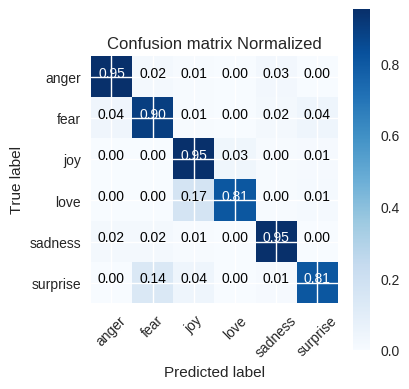

In [0]:
evaluator = Evaluate()

final_predictions = []

for p in all_predictions:
    for sub_p in p:
        final_predictions.append(sub_p)

predictions = [np.argmax(p).item() for p in final_predictions]
targets = [np.argmax(t).item() for t in y_raw]
correct_predictions = float(np.sum(predictions == targets))

# predictions
predictions_human_readable = ((x_raw, predictions))
# actual targets
target_human_readable = ((x_raw,  targets))

emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

# convert results into dataframe
model_test_result = pd.DataFrame(predictions_human_readable[1],columns=["emotion"])
test = pd.DataFrame(target_human_readable[1], columns=["emotion"])

model_test_result.emotion = model_test_result.emotion.map(lambda x: emotion_dict[int(float(x))])
test.emotion = test.emotion.map(lambda x: emotion_dict[int(x)])

evaluator.evaluate_class(model_test_result.emotion, test.emotion );

## Final Words
You have learned how to perform neural-based emotion recognition using RNNs. There are many things you can do after you have completed this tutorial. You can attempt the exercises outlined in the "Outline" section of this notebook. You can also try other types of neural architectures such as LSTMs, Bi-LSTMS, attentions models, and CNNs. In addition, you can also store the models and conduct transfer learning to other emotion-related tasks. 


---

## References

- [Introduction to what is a Tensor](https://www.youtube.com/watch?v=hCSjWCVrphc&t=1137s)
- [Deep Learning for NLP](https://docs.google.com/presentation/d/1cf2H1qMvP1rdKUF5000ifOIRv1_b0bvj0ZTVL7-RaVE/edit?usp=sharing)
- [Enable Eager Execution on TensorFlow](https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/Eager_Execution_Gradient_.ipynb)
- [Basic Text Classification](https://www.tensorflow.org/tutorials/keras/basic_text_classification)
- [Deep Learning for NLP: An Overview of Recent Trends](https://medium.com/dair-ai/deep-learning-for-nlp-an-overview-of-recent-trends-d0d8f40a776d)